**Continued from Part 2 Author Lifespan**

As we saw in Part 1, cross-posting seem to be exceptionally active between mid 2012 and mid 2013 (i.e. peak in the red curve). Generally speaking, posts in **r/MensRights** and **r/Feminism** should be about different topics (of course some may be related), because they are from two different subreddits after all. However, topics will evolve over time, and some factors (e.g. trolling) may cause posts in **r/MensRights** and **r/Feminism** to be limited to a narrow range of topics during some period. If so, posts within this period would likely have similar linguistic patterns (e.g. similar common words).

In this part, we'll compute some quantitative measures of dissmilarity/similarity of linguistic patterns between two corpora (posts from **r/MensRights** and from **r/Feminism**). Specifically, we define

* $C_{M}^{x}(I) = $ corpus of text from cross-posters posted in **r/MensRights**
* $C_{F}^{x}(I) = $ corpus of text from cross-posters posted in **r/Feminism**
* $C_{M}^{o}(I) = $ corpus of text from MensRights-only authors (must be posed in **r/MensRights**)
* $C_{F}^{o}(I) = $ corpus of text from Feminism-only authors (must be posted in **r/Feminism**)

Note that these variables are defined as a function of time interval $I$, which means that only posts within the given time interval $I$ are considered. Also, these variables are represented as distribution of word frequencies. We'll compute similarity measure (Cosine similarity and Jaccard similarity) $\rho(\cdot, \cdot)$ and dissimilarity (Jensen Shannon Divergence) $\delta(\cdot, \cdot)$ between $C_{M}^{x}(I)$ and $C_{F}^{x}(I)$ (for cross-posters), and between $C_{M}^{o}(I)$ and $C_{F}^{o}(I)$

-------------------
First I'll show the steps for computing $C_{M}^{x}(I)$, $C_{F}^{x}(I)$, $C_{M}^{o}(I)$ and $C_{F}^{o}(I)$ with example.

In [1]:
import datetime

import numpy as np
import pandas as pd
from pymongo import MongoClient
import pymongo

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]

In [2]:
db["MensRights"].drop_indexes()
db["MensRights"].create_index([("created_utc", pymongo.ASCENDING)])
db["MensRights"].create_index([("author", pymongo.HASHED)])

db["Feminism"].drop_indexes()
db["Feminism"].create_index([("created_utc", pymongo.ASCENDING)])
db["Feminism"].create_index([("author", pymongo.HASHED)])

u'author_hashed'

Pull data from mongodb. We only want posts between 6/1/2014 and 6/11/2014 (i.e. the interval)

In [3]:
low = datetime.datetime(year=2014, month=6, day=1)
high = datetime.datetime(year=2014, month=6, day=11)

query = db["MensRights"].find({"created_utc": {"$lte": high, "$gte": low}},
                              {"author": 1, "created_utc": 1, "subreddit": 1, "body": 1})
men = pd.DataFrame(list(query))
query = db["Feminism"].find({"created_utc": {"$lte": high, "$gte": low}},
                            {"author": 1, "created_utc": 1, "subreddit": 1, "body": 1})
fem = pd.DataFrame(list(query))
june2014 = pd.concat([men, fem], axis=0)
june2014 = june2014.sort_values(by="created_utc")

`author_info` is indexed by author IDs, and contains the number of unique subreddits (i.e. 1 or 2) of their posts between 6/1/2014 and 6/11/2014

In [4]:
author_info = june2014.groupby("author").apply(lambda df: len(df["subreddit"].unique()))
author_info.name = "subreddits"

author_info = author_info.reset_index(drop=False)

Join `june2014` and `author_info` on author ID

In [5]:
june2014 = june2014.merge(author_info, left_on="author", right_on="author")
june2014 = june2014[["body", "created_utc", "subreddit", "author", "subreddits"]]
june2014[:2]

,body,created_utc,subreddit,author,subreddits
0,I'm mostly confused about her complaints becau...,2014-06-01 00:00:18,MensRights,termd,1
1,No.\n\nI'm also not a drunken idiot and don't ...,2014-06-01 00:04:37,MensRights,termd,1


`body`, `created_utc` and `subreddit` contain information about each post, while `author` and `subreddits` contain information about the post's author.

The `subreddits` column for **cross-posters** contain 2's, and 1's for **MensRight-only** and **Feminism-only**.

First we take a sample of **cross-posters** IDs:

In [6]:
june2014[june2014["subreddits"] == 2]["author"].unique()[:5]

array([u'autowikibot', u'RedRobin77', u'phatphace', u'Astiolo', u'deit9000'], dtype=object)

A sample of **MensRights-only** author IDs:

In [7]:
june2014[(june2014["subreddits"] == 1) & (june2014["subreddit"] == "MensRights")]["author"].unique()[:5]

array([u'termd', u'Piroko', u'not_just_amwac', u'Dann01', u'Meistermalkav'], dtype=object)

A sample of **Feminism-only** author IDs:

In [8]:
june2014[(june2014["subreddits"] == 1) & (june2014["subreddit"] == "Feminism")]["author"].unique()[:5]

array([u'arwenface', u'FoKFill', u'a_grotesqueanimal', u'sinn7',
       u'IndieLady'], dtype=object)

Next we take sample of posts from **cross-poster** `Astiolo`

In [9]:
june2014[june2014["author"] == "Astiolo"]

,body,created_utc,subreddit,author,subreddits
2441,I don't really see her view as particularly co...,2014-06-01 05:16:30,MensRights,Astiolo,2
2442,"I think the biologist was spot on with this, s...",2014-06-06 15:52:29,Feminism,Astiolo,2


Sample of posts from **MensRights-only** `termd`

In [10]:
june2014[june2014["author"] == "termd"]

,body,created_utc,subreddit,author,subreddits
0,I'm mostly confused about her complaints becau...,2014-06-01 00:00:18,MensRights,termd,1
1,No.\n\nI'm also not a drunken idiot and don't ...,2014-06-01 00:04:37,MensRights,termd,1


Sample of posts from **Feminism-only** `arwenface`

In [11]:
june2014[june2014["author"] == "arwenface"]

,body,created_utc,subreddit,author,subreddits
998,"The pink dump truck is a nice touch, though.",2014-06-01 01:06:18,Feminism,arwenface,1


Using the notation defined previously, 

$C_{M}^{x}(I) =$ `["I don't really see her view as particularly co...", ...]`

$C_{F}^{X}(I) =$ `["I think the biologist was spot on with this, s...", ...]`

$C_{M}^{o}(I) =$ `["I'm mostly confused about her complaints becau...", "No.\n\nI'm also not a drunken idiot and don't ...", ...]`

$C_{F}^{o}(I) =$ `["The pink dump truck is a nice touch, though.", ...]`

where $I$ = [6/1/2014, 6/11/2014]

### Compute the data for plotting the similarity/dissimilarity curves

To plot the curves, we need to know the list of **cross-posters**, **MensRights-only** and **Feminism-only** authors within each interval $I$

Specifically, we need to build a dataframe indexed on individual dates that contains the list of authors from groups within a +/-5 day interval:
* cross-posters
* MensRights-only authors
* Feminism-only authors

As we did previously in Part 1, we define a helper function authorlist_by_date for data transformation:
* Pull the data from Mongodb and store the data in dataframe
* Do a "group by" on the dataframe with the key being the individual date

In [12]:
def authorlist_by_date(subreddit):
    df = pd.DataFrame(list(db[subreddit].find({},
                                              {"author": 1, "created_utc": 1, "subreddit": 1, "body": 1})))
    
    gb_key = df["created_utc"].map(lambda d: datetime.datetime(d.year, d.month, d.day))
    df["gb_key"] = gb_key
    author_groupby_day = df.groupby(gb_key).apply(lambda x: x["author"].unique())
    return author_groupby_day

men_author_groupby_day = authorlist_by_date("MensRights")
fem_author_groupby_day = authorlist_by_date("Feminism")

In [13]:
men_author_groupby_day[:2]

created_utc
2008-03-21      [kanuk876]
2008-03-24    [WorcesterM]
dtype: object

In [14]:
fem_author_groupby_day[:2]

created_utc
2009-02-06    [stellar1]
2009-04-13      [Smight]
dtype: object

Now concatenate them along axis=1. Note the indices are automatically aligned

In [15]:
author_groupby_day = pd.concat([men_author_groupby_day, fem_author_groupby_day],
                               axis=1, keys=["men_author", "fem_author"])
author_groupby_day = author_groupby_day.sort_index(axis=0)
author_groupby_day[-2:]

,men_author,fem_author
created_utc,,
2016-07-30,"[Real_nimr0d, elebrin, sillymod, JohnKimble111...","[Amvega, demmian, conuly, Hobbes_the_tiger, Ad..."
2016-07-31,"[Lethn, hhamama66, civilsaint, Foregen_Is_Life...","[polot38, HeavenlySun, weinbrandbabsi, raloicl..."


For example, `[Real_nimr0d, elebrin, sillymod, JohnKimble111...` are the users who posted in **r/MensRights** on 2016-07-30, and `[Amvega, demmian, conuly, Hobbes_the_tiger, Ad...` are those who posted in **r/Feminism** on 2016-07-30.

Remember that $C_{M}^{x}(I)$, $C_{F}^{x}(I)$, $C_{M}^{o}(I)$ and $C_{F}^{o}(I)$ are computed over a 10-day interval (+/-5 days). To achieve this, we need a helper function `group_author` that merges the author lists in dataframe `author_groupby_day`:

In [16]:
radius = 5

def group_author(row, radius=5):
    """
    `row`: Series
    `row.name`: index value of the row (i.e. datetime)
    
    returns series containing three entries:
        `cp`: crossposters
        `men_only`: MensRights-only
        `fem_only`: Feminism-only
    """
    date = row.name
    days = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    men_author = []
    fem_author = []
    for d in days:
        if d in author_groupby_day.index:
            if author_groupby_day.ix[d, "men_author"] is not np.nan:
                men_author.extend(list(author_groupby_day.ix[d, "men_author"]))
            if author_groupby_day.ix[d, "fem_author"] is not np.nan:
                fem_author.extend(list(author_groupby_day.ix[d, "fem_author"]))

    men_author = set(men_author)
    fem_author = set(fem_author)
    # crssposter would just be the intersection
    crossposter = men_author & fem_author
    men_only = men_author - crossposter
    fem_only = fem_author - crossposter

    return pd.Series([list(crossposter), list(men_only), list(fem_only)], index=["cp", "men_only", "fem_only"])

Apply the function `group_author` on each row of dataframe `author_groupby_day`

In [17]:
author_group = author_groupby_day.apply(lambda row: group_author(row, radius), axis=1)
author_group[-5:]

,cp,men_only,fem_only
created_utc,,,
2016-07-27,"[Azure9861, i_have_a_semicolon, omegaphallic, ...","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Moal, Jessicorama, snarky_llama, AnAccountFor..."
2016-07-28,"[Azure9861, omegaphallic, i_have_a_semicolon, ...","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Moal, Jessicorama, snarky_llama, iMakeGreatDe..."
2016-07-29,"[Azure9861, omegaphallic, i_have_a_semicolon]","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Moal, Jessicorama, snarky_llama, iMakeGreatDe..."
2016-07-30,"[Azure9861, omegaphallic, i_have_a_semicolon]","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Jessicorama, snarky_llama, iMakeGreatDeals, M..."
2016-07-31,"[Azure9861, omegaphallic, i_have_a_semicolon]","[Lost-In-Quaice, locks_are_paranoid, thesimen1...","[Jessicorama, iMakeGreatDeals, sweet-potat0, B..."


In `author_group`

* `[Azure9861, i_have_a_semicolon, omegaphallic, ...` are those who posted in both **r/MensRights** and **r/Feminism** within the invertal [2016-07-22, 2016-07-31] (centered on 2016-07-27)
* `[Lost-In-Quaice, locks_are_paranoid, thesimen1...` are those who posted only in **r/MensRights** within the invertal [2016-07-22, 2016-07-31] (centered on 2016-07-27)
* `[Moal, Jessicorama, snarky_llama, AnAccountFor...` are those who posted only in **r/Feminism** within the invertal [2016-07-22, 2016-07-31] (centered on 2016-07-27)


We will store the content of dataframe `author_group` into mongodb:

In [18]:
collection = db["author_group"]
collection.insert_many(author_group.T.to_dict().values())

### Preprocessing the text

The next step is to preprocess the raw text of each post: we need to remove tags, stem/lemmatize the words, remove stop words, and optionally, keeping only adjectives, nouns, and verbs, because they carry sentiment meanings. I wrote a module ***[preprocess.py](https://github.com/chao-ji/reddit/blob/master/preprocess.py)*** that contains functions for transforming text into list of tokens.

Here is a concrete example of how the raw text is transformed into clean list of tokens:

In [19]:
from preprocess import *

print "Raw text:\n%r" % men[:1]["body"].values[0]
print 
print "List of words (nouns, adjectives and verbs only):"
print get_reddit_tokens(men[:1]["body"].iloc[0], njv_only=True)[:10]

Raw text:
u"I'm mostly confused about her complaints because new amazon employees aren't in her age group. She's 40. Most of the new hires are 15+ years younger than her."

List of words (nouns, adjectives and verbs only):
[u'confused', u'complaint', u'new', u'amazon', u'employee', u'age', u'group', u'new', u'hire', u'year']


Now let's apply this function `get_reddit_tokens` on each post, and save the lits of tokens in the field `tokens_njv`

In [20]:
for subreddit in ("MensRights", "Feminism"):
    collection = db[subreddit]

    ids = list(collection.find({}, {"_id": 1}))
    for one_id in ids:
        post= collection.find_one(one_id)
        body = post["body"]
        tokens = get_reddit_tokens(body, njv_only=True)
        collection.update_one(one_id, {"$set": {"tokens_njv": " ".join(tokens)}})

The tokens are stored in the `tokens_njv` field in each document

In [21]:
collection = db["MensRights"]
collection.find_one()

{u'_id': ObjectId('57c5ddd779a3030ce06585e6'),
 u'archived': True,
 u'author': u'sibqm_lmvm',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u"That event actually happened when I was in sixth grade, way back in the day :)\n\nIm actually studying to be a teacher right now though, and I'd like to be as egalitarian as possible. But I might switch my major to something involving abnormal psych, where I'll have to be extremely non-judging.",
 u'controversiality': 0,
 u'created_utc': datetime.datetime(2012, 4, 30, 20, 0, 15),
 u'date': datetime.datetime(2012, 4, 30, 0, 0),
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'c4iiwis',
 u'link_id': u't3_t03pt',
 u'name': u't1_c4iiwis',
 u'parent_id': u't1_c4iiupq',
 u'removal_reason': nan,
 u'retrieved_on': 1428829641,
 u'score': 2,
 u'score_hidden': False,
 u'subreddit': u'MensRights',
 u'subreddit_id': u't5_2qhk3',
 u'tokens_njv': u'event happen sixth grade way day study teacher right 

`crossposter` and `non_crossposters` store the list of crossposters and non-crossposters (i.e. MensRights-only and Feminism-only) of each 10-day interval centered on the date in the `created_utc` columns. These two dataframes will be used for retrieving the tokens from these authors from mongodb.

In [22]:
crossposter = author_group[author_group["cp"].map(len) > 0]["cp"]
crossposter = crossposter.reset_index()
crossposter[:5]

,created_utc,cp
0,2009-05-07,[darkreign]
1,2009-05-08,[darkreign]
2,2009-05-09,[darkreign]
3,2009-05-10,[darkreign]
4,2009-05-11,[darkreign]


In [23]:
non_crossposter = author_group[(author_group["men_only"].map(len) > 0) &
                                         (author_group["fem_only"].map(len) > 0)][["men_only", "fem_only"]]
non_crossposter = non_crossposter.apply(lambda row: row["men_only"] + row["fem_only"], axis=1)
non_crossposter = non_crossposter.reset_index()
non_crossposter[:5]

,created_utc,0
0,2009-02-02,"[Eever, Saydrah, ermine, IEatBabies, thomashau..."
1,2009-02-03,"[Eever, Saydrah, ermine, IEatBabies, thomashau..."
2,2009-02-04,"[Eever, Saydrah, ermine, IEatBabies, thomashau..."
3,2009-02-05,"[Eever, Saydrah, ermine, IEatBabies, thomashau..."
4,2009-02-06,"[Saydrah, steelfrog, IEatBabies, thomashauk, O..."


Now let's define a helper function `author2counter` that retrieves the tokens (noun, adjective, verbs) from mongodb for the author list in each row of `crossposter` and `non_crossposter`

Note that an index has already been created on the field `created_utc`, so the query should be fairly fast

In [24]:
from collections import Counter

def author2counter(row, radius=5):
    date = row.iloc[0]
    authors = row.iloc[1]
    
    low = date + datetime.timedelta(days=-radius)
    high = date + datetime.timedelta(days=radius)
       
    counters = []
    for subreddit in ("MensRights", "Feminism"):
        c = Counter()
        
        query = db[subreddit].find
        
        for author in authors:
            query = db[subreddit].find({"author": author,
                                        "created_utc": {"$lte": high, "$gte": low}},
                                       {"tokens_njv": 1})
            results = list(query)
            for doc in results:
                c.update(filter(lambda token: len(token) > 0, doc["tokens_njv"].split(" ")))
        counters.append(c)
        
    s = pd.Series(counters)
    s.index = ("from_mensrights", "from_feminism")
    return s

Apply function `author2counter` on each row of `crossposter` and `non_crossposter`:

In [25]:
counter_crossposter = crossposter.apply(author2counter, axis=1)
counter_crossposter.index = crossposter["created_utc"]
counter_crossposter[:5]

,from_mensrights,from_feminism
created_utc,,
2009-05-07,"{u'motherfucking': 1, u'snack': 1, u'bacon': 1...","{u'woman': 1, u'technology': 1, u'men': 1, u'k..."
2009-05-08,"{u'motherfucking': 1, u'snack': 1, u'bacon': 1...","{u'woman': 1, u'technology': 1, u'men': 1, u'k..."
2009-05-09,"{u'motherfucking': 1, u'snack': 1, u'bacon': 1...","{u'woman': 1, u'technology': 1, u'men': 1, u'k..."
2009-05-10,"{u'motherfucking': 1, u'snack': 1, u'bacon': 1...","{u'woman': 1, u'technology': 1, u'men': 1, u'k..."
2009-05-11,"{u'motherfucking': 1, u'snack': 1, u'bacon': 1...","{u'woman': 1, u'technology': 1, u'men': 1, u'k..."


In [26]:
counter_non_crossposter = non_crossposter.apply(author2counter, axis=1)
counter_non_crossposter.index = non_crossposter["created_utc"]
counter_non_crossposter[:5]

,from_mensrights,from_feminism
created_utc,,
2009-02-02,"{u'limited': 3, u'perpetual-children': 1, u'no...","{u'interesting': 1, u'notion': 1}"
2009-02-03,"{u'limited': 3, u'perpetual-children': 1, u'dy...","{u'interesting': 1, u'notion': 1}"
2009-02-04,"{u'limited': 4, u'protestant': 1, u'suicidal':...","{u'interesting': 1, u'notion': 1}"
2009-02-05,"{u'limited': 5, u'protestant': 1, u'suicidal':...","{u'interesting': 1, u'notion': 1}"
2009-02-06,"{u'limited': 5, u'protestant': 1, u'suicidal':...","{u'interesting': 1, u'notion': 1}"


Note that we're done with computing $C_{M}^{x}(I)$, $C_{F}^{x}(I)$, $C_{M}^{o}(I)$ and $C_{F}^{o}(I)$:
* $C_{M}^{x}(I) = $ column `from_mensrights` of `counter_crossposter`
* $C_{F}^{x}(I) = $ column `from_feminism` of `counter_crossposter`
* $C_{M}^{o}(I) = $ column `from_mensrights` of `counter_non_crossposter`
* $C_{F}^{o}(I) = $ column `from_feminism` of `counter_non_crossposter`

For example `{u'interesting': 1, u'notion': 1}` with index `2009-02-06` corresponds to the word frequencies of posts in **r/MensRights** from **MensRights-only** between 2009-02-01 and 2009-02-10

------------------

### Compute similarity/dissimilarity metrics

Now that we're done with all the setups, we're ready to comput the similarity/dissimilarity metrics:

* Jaccard Similarity: ratio of number of words shared between the two counters over the size of their union
* Cosine Similarity: the two counters are unioned such that words that appear only in one counter get a pseudo count of 1
* Jensen Shannon Divergence: same as cosine similarity

Note for each of the following function `jaccard`, `cosine_sim`, `jsd`, we're cosidering only the top 10 percent most common words (i.e. `perc=0.1`)

In [27]:
from scipy.spatial.distance import cosine
from scipy.stats import entropy

def jaccard(row, perc=0.1):
    """Jaccard Similarity"""
    a = row["from_mensrights"]
    b = row["from_feminism"]

    len_a = len(a)
    len_b = len(b)

    if int(len_a * perc) >= 1 and int(len_b * perc) >= 1:
        a = a.most_common(int(len_a * perc))
        b = b.most_common(int(len_b * perc))
    else:
        a = a.most_common(len_a)
        b = b.most_common(len_b)

    a = set(dict(a).keys())
    b = set(dict(b).keys())

    return len(a & b) / float(len(a | b))

def cosine_sim(row, perc=0.1):
    """cosine similarity"""
    a = row["from_mensrights"]
    b = row["from_feminism"]

    len_a = len(a)
    len_b = len(b)

    if int(len_a * perc) >= 1 and int(len_b * perc) >= 1:
        a = a.most_common(int(len_a * perc))
        b = b.most_common(int(len_b * perc))
    else:
        a = a.most_common(int(len_a))
        b = b.most_common(int(len_b))

    a = set(dict(a).keys())
    b = set(dict(b).keys())
    c = a | b
    c = list(c)

    a = np.array(map(lambda x: float(row["from_mensrights"][x]) if x in row["from_mensrights"] else 0., c))
    b = np.array(map(lambda x: float(row["from_feminism"][x]) if x in row["from_feminism"] else 0., c))
    a = a + 1
    b = b + 1

    r = 1 - cosine(a, b)

    return r

def jsd(row, perc=0.1):
    """Jensen Shannon divergence"""

    a = row["from_mensrights"]
    b = row["from_feminism"]

    len_a = len(a)
    len_b = len(b)

    if int(len_a * perc) >= 1 and int(len_b * perc) >= 1:
        a = a.most_common(int(len_a * perc))
        b = b.most_common(int(len_b * perc))
    else:
        a = a.most_common(int(len_a))
        b = b.most_common(int(len_b))

    a = set(dict(a).keys())
    b = set(dict(b).keys())

    c = a | b
    c = list(c)
    a = np.array(map(lambda x: float(row["from_mensrights"][x]) if x in row["from_mensrights"] else 0., c))
    b = np.array(map(lambda x: float(row["from_feminism"][x]) if x in row["from_feminism"] else 0., c))
    a = a + 1
    b = b + 1

    avg = (a + b) / 2.
    return (entropy(a, avg, base=2.) + entropy(b, avg, base=2.)) / 2.


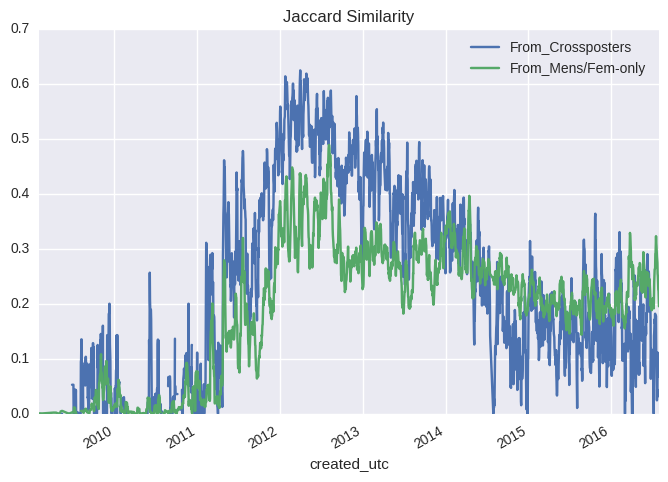

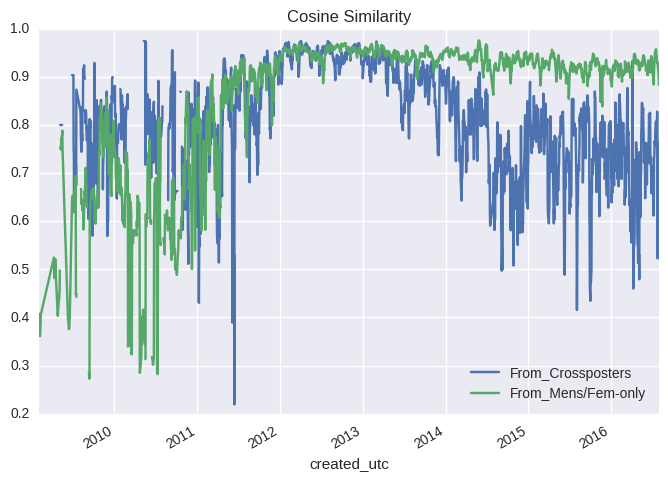

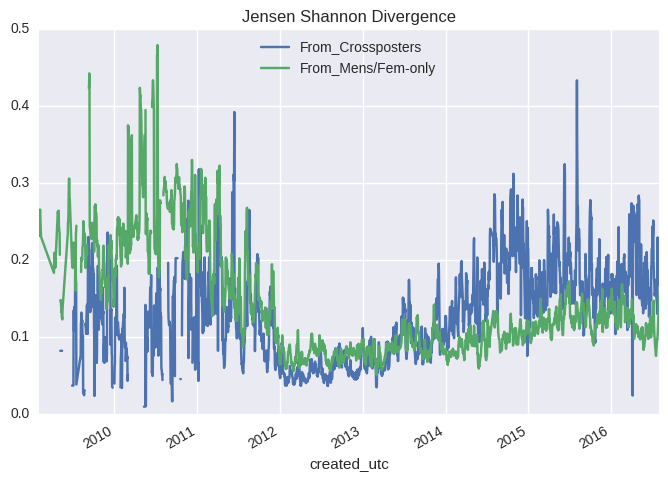

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

for func, name in zip((jaccard, cosine_sim, jsd),
                      ("Jaccard Similarity", "Cosine Similarity", "Jensen Shannon Divergence")):

    series_crossposter = counter_crossposter.apply(func, axis=1)    
    series_non_crossposter = counter_non_crossposter.apply(func, axis=1)

    df = pd.concat([series_crossposter, series_non_crossposter], axis=1,
                   keys=["From_Crossposters", "From_Mens/Fem-only"])
    df.plot()
    plt.title(name)
    plt.show()

As we can see, the word frequencies of posts from **r/MensRights** and **r/Feminism** seem to be more similar during mid 2012 and mid 2013 than anywhere else. This is the case even for non-crossposters (i.e. MensRights-only and Feminism-only)

### Wordcloud

Wordcloud (https://github.com/amueller/word_cloud) is an intuitive way to visualize the most frequent words from a corpus. We'll use wordcloud on the posts between mid 2012 and mid 2013. 

In [29]:
low = datetime.datetime(year=2012, month=6, day=1)
high = datetime.datetime(year=2013, month=6, day=1)

counters = []
for subreddit in ("MensRights", "Feminism"):
    query = db[subreddit].find({"created_utc": {"$lte": high, "$gte": low}}, {"tokens_njv": 1})
    
    results = list(query)
    
    c = Counter()
    for doc in results:
        c.update(filter(lambda token: len(token) > 0, doc["tokens_njv"].split(" ")))
    counters.append(c)

In [30]:
mensrights_counter = counters[0]
mensrights_counter.most_common(10)

[(u'woman', 247949),
 (u'men', 199934),
 (u'get', 132788),
 (u'say', 130361),
 (u'people', 119032),
 (u'think', 111587),
 (u'make', 108445),
 (u'go', 86251),
 (u'feminist', 79889),
 (u'want', 72997)]

In [31]:
feminism_counter = counters[1]
feminism_counter.most_common(10)

[(u'woman', 44409),
 (u'men', 27532),
 (u'people', 24197),
 (u'think', 23205),
 (u'say', 23023),
 (u'make', 18773),
 (u'get', 17094),
 (u'rape', 13279),
 (u'feminist', 12522),
 (u'thing', 12489)]

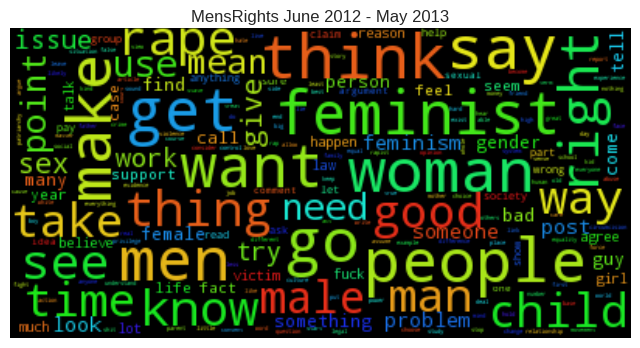

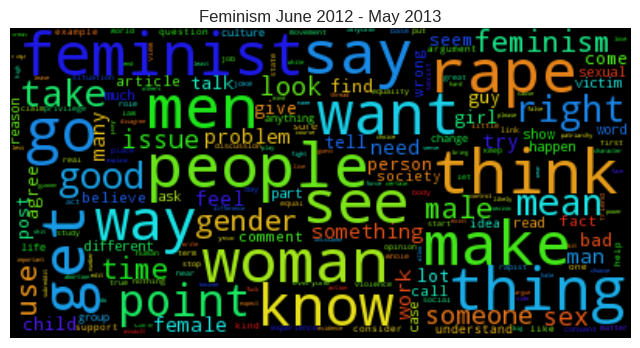

In [32]:
from wordcloud import WordCloud

wc_men = WordCloud(max_font_size=40).generate_from_frequencies((k, mensrights_counter[k]) for k in mensrights_counter.keys())
wc_fem = WordCloud(max_font_size=40).generate_from_frequencies((k, feminism_counter[k]) for k in feminism_counter.keys())

plt.imshow(wc_men)
plt.title("MensRights June 2012 - May 2013")
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(wc_fem)
plt.title("Feminism June 2012 - May 2013")
plt.xticks([])
plt.yticks([])
plt.show()